In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/'
!kaggle datasets download -d ssismasterchief/machine-hack-fake-news-content-detection 
!unzip machine-hack-fake-news-content-detection.zip

  0% 0.00/560k [00:00<?, ?B/s]
100% 560k/560k [00:00<00:00, 101MB/s]
Archive:  machine-hack-fake-news-content-detection.zip
  inflating: Test.csv                
  inflating: Train.csv               
  inflating: sample submission.csv   


In [4]:
data = pd.read_csv("Train.csv")

In [5]:
data.head()

,Labels,Text,Text_Tag
0,1,Says the Annies List political group supports ...,abortion
1,2,When did the decline of coal start? It started...,"energy,history,job-accomplishments"
2,3,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy
3,1,Health care reform legislation is likely to ma...,health-care
4,2,The economic turnaround started at the end of ...,"economy,jobs"


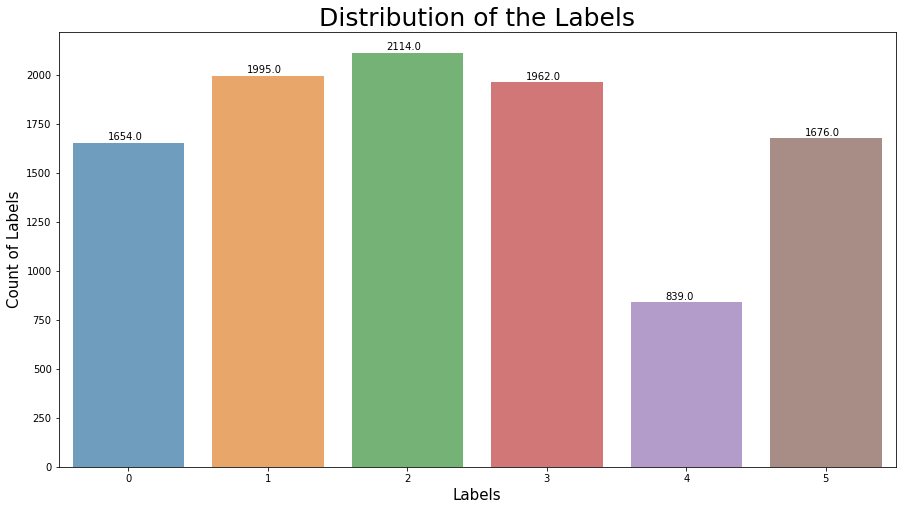

In [7]:
plt.figure(figsize = (15,8))
graph = sns.countplot(data = data, x="Labels", alpha=0.7)
for p in graph.patches:
    graph.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+15))
plt.title("Distribution of the Labels",fontsize=25)
plt.ylabel('Count of Labels', fontsize=15)
plt.xlabel('Labels', fontsize=15)
plt.show()

In [14]:
import nltk
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------

Download which package (l=list; x=cancel)?


       | 
       | Downloading package abc to /root/nltk_data...
       |   Unzipping corpora/abc.zip.
       | Downloading package alpino to /root/nltk_data...
       |   Unzipping corpora/alpino.zip.
       | Downloading package averaged_perceptron_tagger to
       |     /root/nltk_data...
       |   Unzipping taggers/averaged_perceptron_tagger.zip.
       | Downloading package averaged_perceptron_tagger_ru to
       |     /root/nltk_data...
       |   Unzipping taggers/averaged_perceptron_tagger_ru.zip.
       | Downloading package basque_grammars to /root/nltk_data...
       |   Unzipping grammars/basque_grammars.zip.
       | Downloading package biocreative_ppi to /root/nltk_data...
       |   Unzipping corpora/biocreative_ppi.zip.
       | Downloading package bllip_wsj_no_aux to /root/nltk_data...
       |   Unzipping models/bllip_wsj_no_aux.zip.
       | Downloading package book_grammars to /root/nltk_data...
       |   Unzipping grammars/book_grammars.zip.
       | Downloading 


---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


True

In [11]:
from nltk.corpus import stopwords
import string

In [15]:
data['Text'] = data['Text'].str.lower()
stop_words = set(stopwords.words('english'))

data['new_text'] = data['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words) and len(word) > 2]))
print('With Stopwords: ')
print(data['Text'][1])
print('\n')
print('Without Stopwords: ')
print(data['new_text'][1])

With Stopwords: 
when did the decline of coal start? it started when natural gas took off that started to begin in (president george w.) bushs administration.


Without Stopwords: 
decline coal start? started natural gas took started begin (president george w.) bushs administration.


In [16]:
punctuations = list(string.punctuation)

data['clean_text'] = data['new_text'].str.replace('[^\w\s]','')
print('With Punctuation: ')
print(data['new_text'][1])
print('\n')
print('Without Punctuation: ')
print(data['clean_text'][1])

With Punctuation: 
decline coal start? started natural gas took started begin (president george w.) bushs administration.


Without Punctuation: 
decline coal start started natural gas took started begin president george w bushs administration


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [17]:
from wordcloud import WordCloud

(-0.5, 979.5, 879.5, -0.5)

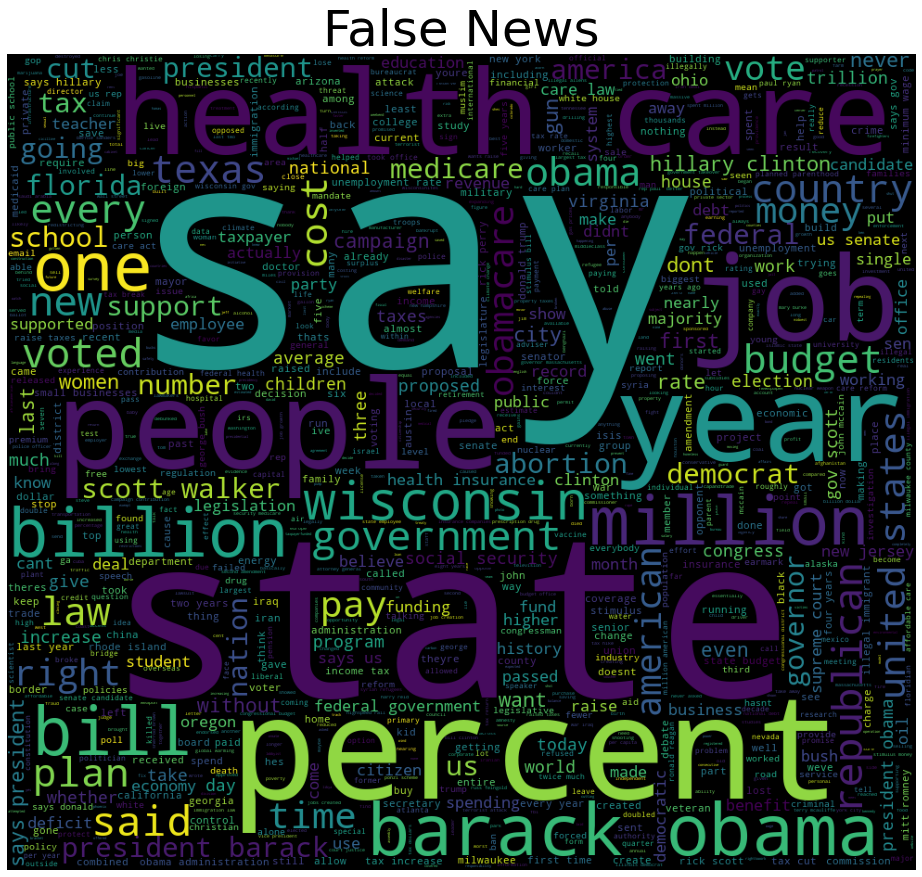

In [21]:
cloud = WordCloud(width=980, height= 880,max_words= 980).generate(' '.join(data[data['Labels']==1]['clean_text'].astype(str)))
plt.figure(figsize=(20, 15))
plt.title('False News', fontsize = 50)
plt.imshow(cloud)
plt.axis('off')

In [22]:
num_classes = (data['Labels'].nunique())

In [23]:
import tensorflow as tf

In [24]:
X = data['clean_text']
y = tf.keras.utils.to_categorical(data['Labels'], num_classes)

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [29]:
train_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<OOV>')
train_tokenizer.fit_on_texts(X_train.values)
train_word_index = train_tokenizer.word_index

In [30]:
vocab_length = len(train_word_index) + 1
vocab_length

11956

In [31]:
train_sequences = train_tokenizer.texts_to_sequences(X_train)
len(train_sequences)

8192

In [33]:
test_sequences = train_tokenizer.texts_to_sequences(X_test)
len(test_sequences)

2048

In [34]:
maxlen=20
train_padded_seqeunces = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, padding='post', maxlen=maxlen, truncating='post')
test_padded_seqeunces = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, padding='post', maxlen=maxlen, truncating='post')

In [38]:
!pip install tensorflow_addons
import tensorflow_addons as tfa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.2 MB/s 


In [39]:
embedding_dim = 6
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_length, embedding_dim, input_length=maxlen),
    tf.keras.layers.SimpleRNN(64, activation='tanh', return_sequences=True),
    tf.keras.layers.SimpleRNN(32, activation='tanh', return_sequences=True),
    tf.keras.layers.SimpleRNN(16, activation='tanh'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=tfa.metrics.F1Score(num_classes=num_classes))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 6)             71736     
                                                                 
 simple_rnn (SimpleRNN)      (None, 20, 64)            4544      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 20, 32)            3104      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 16)                784       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dense_1 (Dense)             (None, 6)                 1

In [40]:
history = model.fit(train_padded_seqeunces, y_train, epochs=20, validation_data=(test_padded_seqeunces, y_test))


Epoch 1/20
256/256 [==============================] - 16s 36ms/step - loss: 1.7770 - f1_score: 0.1497 - val_loss: 1.7597 - val_f1_score: 0.0738
Epoch 2/20
256/256 [==============================] - 9s 35ms/step - loss: 1.7379 - f1_score: 0.1819 - val_loss: 1.7692 - val_f1_score: 0.1588
Epoch 3/20
256/256 [==============================] - 8s 31ms/step - loss: 1.6257 - f1_score: 0.2848 - val_loss: 1.8365 - val_f1_score: 0.1523
Epoch 4/20
256/256 [==============================] - 6s 24ms/step - loss: 1.4072 - f1_score: 0.4090 - val_loss: 2.0602 - val_f1_score: 0.1696
Epoch 5/20
256/256 [==============================] - 6s 22ms/step - loss: 1.1498 - f1_score: 0.5424 - val_loss: 2.2999 - val_f1_score: 0.1750
Epoch 6/20
256/256 [==============================] - 4s 15ms/step - loss: 0.8960 - f1_score: 0.6517 - val_loss: 2.6316 - val_f1_score: 0.1675
Epoch 7/20
256/256 [==============================] - 4s 15ms/step - loss: 0.7167 - f1_score: 0.7314 - val_loss: 2.9216 - val_f1_score: 0.157

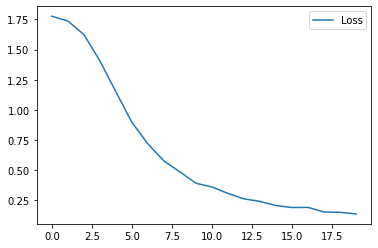

In [42]:
plt.plot(history.history['loss'], label='Loss')
plt.legend()
plt.show()

In [41]:
from sklearn.metrics import f1_score, log_loss, multilabel_confusion_matrix

In [43]:
model.evaluate(test_padded_seqeunces, y_test)

64/64 [==============================] - 0s 6ms/step - loss: 5.3618 - f1_score: 0.1847


[5.361778259277344,
 array([0.2087447 , 0.1833811 , 0.16687116, 0.23557691, 0.10029498,
        0.21337128], dtype=float32)]

In [44]:
test_prob = model.predict(test_padded_seqeunces)
test_pred = np.where(test_prob > 0.5, 1, 0)

64/64 [==============================] - 1s 7ms/step


In [45]:
print("Log-Loss: ", log_loss(y_test, test_prob))
print("F1-Score: ", f1_score(y_test, test_pred, average = 'weighted'))

Log-Loss:  5.361778619943436
F1-Score:  0.18859204505459387


Variable Description:

Text - Raw content from social media/ new platforms

Text_Tag - Different types of content tags

Labels - Represents various classes of Labels

● Barely-True - 0

● False - 1

● Half-True - 2

● Mostly-True - 3

● Not-Known - 4

● True - 5

In [46]:
labels = ['Barely-True', 'False', 'Half-True', 'Mostly-True', 'Not-Known', 'True']
conf_mat = multilabel_confusion_matrix(y_test, test_pred)

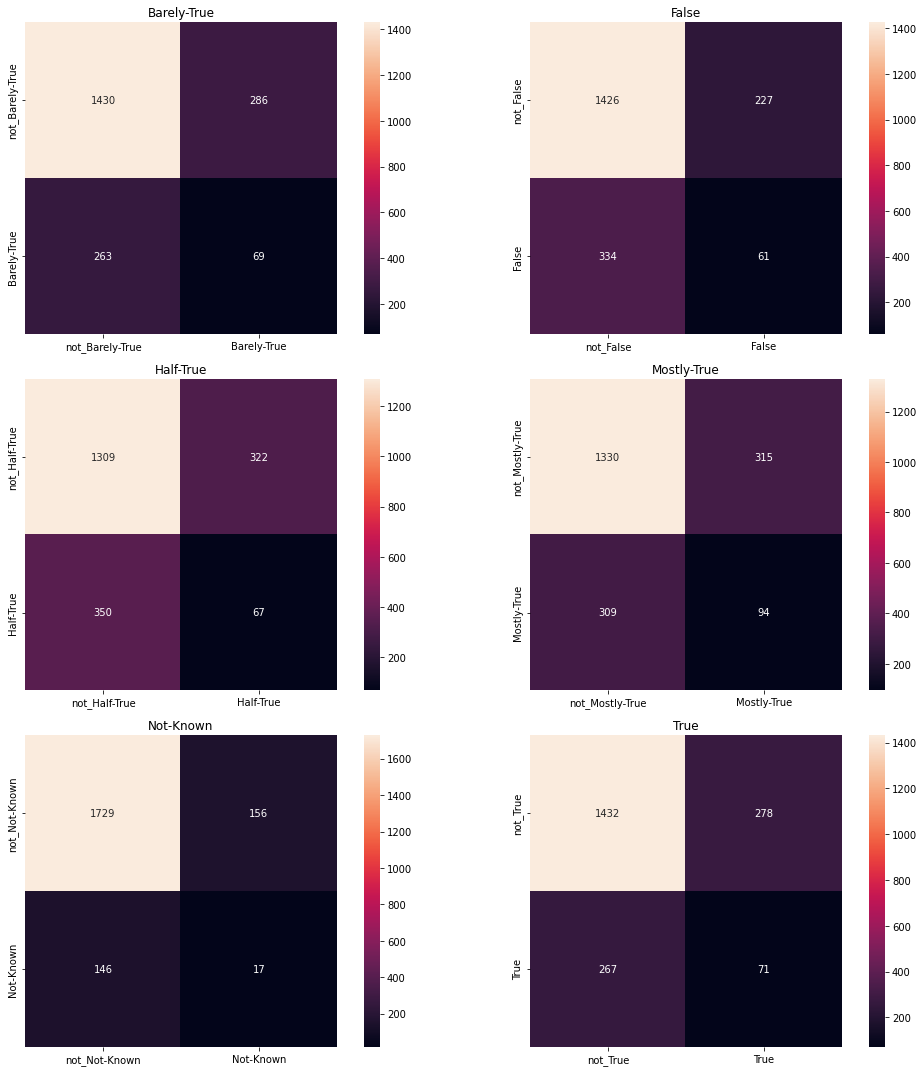

In [47]:
fig = plt.figure(figsize = (15, 15))
for i, (label, matrix) in enumerate(zip(labels, conf_mat)):
    plt.subplot(3, 2, i+1)
    l = [f'not_{label}', label]
    sns.heatmap(matrix, annot = True, square = True, xticklabels = l, yticklabels = l, fmt='d')
    plt.title(label)
plt.tight_layout()
plt.show()